In [36]:
using JuMP
using Ipopt
using DataArrays, DataFrames, CSV
using Gadfly
using KNITRO

# Data initialization

In [37]:
#Generator's parameters

GenData = DataFrame(
    Bus = [18,21,1,2,15,16,23,23,7,13,15,22],
    Pmax = [400,400,152,152,155,155,310,350,350,591,60,300],
    Pmin = [100,100,30.40,30.40,54.25,54.25,108.50,140,75,206.85,12,0],
    a = [0.005,0.005,0.004,0.004,0.005,0.007,0.007,0.003,0.004,0.005,0.007,0],
    b = [5.47,5.47,13.32,13.32,16,10.52,10.52,10.89,20.7,20.93,26.11,0],
    c = [89,89,100,100,53,73,73,80,83,87,53,0],
    RU = [47,47,14,14,21,21,21,28,49,21,7,35],
    RD = [47,47,14,14,21,21,21,28,49,21,7,35])

#Number of generators
NGen = size(GenData,1)
# Generator limits
Pmin = zeros(NGen); 
Pmax = zeros(NGen); 
Qmin = zeros(NGen); 
Qmax = zeros(NGen);
# Price coefficients
a = zeros(NGen);
b = zeros(NGen);
c = zeros(NGen);
Bus = zeros(NGen);
#RumpUp
RU = zeros(NGen);
#RumpDown
RD = zeros(NGen);

for i=1:NGen
    Bus[i] = GenData[i,:Bus]
    Pmin[i] = GenData[i,:Pmin]
    Pmax[i] = GenData[i,:Pmax]
    a[i] = GenData[i,:a]
    b[i] = GenData[i,:b]
    c[i] = GenData[i,:c]
    RU[i] = GenData[i,:RU]
    RD[i] = GenData[i,:RD]
    
end    
    
#GenData

In [38]:
# Transmission line's parameters
BranchData = DataFrame(
    FromBus = [1,1,1,2,2,3,3,4,5,6,7,8,8,9,9,10,10,11,11,12,12,13,14,15,15,15,16,16,17,17,18,19,20,21],
    ToBus = [2,3,5,4,6,9,24,9,10,10,8,9,10,11,12,11,12,13,14,13,23,23,16,16,21,24,17,19,18,22,21,20,23,22],
    r = [0.0026,0.0546,0.0218,0.0328,0.0497,0.0308,0.0023,0.0268,0.0228,0.0139,0.0159,0.0427,0.0427,0.0023,0.0023,0.0023,0.0023,0.0061,0.0054,0.0061,0.0124,0.0111,0.0050,0.0022,0.0032,0.0067,0.0033,0.0030,0.0018,0.0135,0.0017,0.0026,0.0014,0.0087],
    x = [0.0139,0.2112,0.0845,0.1267,0.1920,0.1190,0.0839,0.1037,0.0883,0.0605,0.0614,0.1651,0.1651,0.0839,0.0839,0.0839,0.0839,0.0476,0.0418,0.0476,0.0966,0.0865,0.0389,0.0173,0.0245,0.0519,0.0259,0.0231,0.0144,0.1053,0.0130,0.0198,0.0108,0.0678],
    b = [0.4611,0.0572,0.0229,0.0343,0.0520,0.0322,0.0000,0.0281,0.0239,2.4590,0.0166,0.0447,0.0447,0.0000,0.0000,0.0000,0.0000,0.0999,0.0879,0.0999,0.2030,0.1818,0.0818,0.0364,0.2060,0.1091,0.0545,0.0485,0.0303,0.2212,0.1090,0.1666,0.0910,0.1424],
    Smax = [175,175,175,175,175,175,400,175,175,175,175,175,175,400,400,400,400,500,500,500,500,500,500,500,1000,500,500,500,500,500,1000,1000,1000,500],)

#Number of Buses
NBuses = max(maximum(BranchData[:,:FromBus]), maximum(BranchData[:,:ToBus]));
#Number of Lines
NLines = size(BranchData,1);
#calculations of admittance and impedance
BranchData[:Z]=BranchData[:r]+im*BranchData[:x];
BranchData[:Y]=1./BranchData[:Z];

Ybus = zeros(Complex,NBuses,NBuses);#Admittance matrix
Nodes = zeros(Int8,NLines,2); #node's matrix
SLmax = zeros(NLines); #line limits
x = zeros(NLines);
r = zeros(NLines);

for i=1:NLines
    #Admittance matrix
    Ybus[BranchData[i,:FromBus],BranchData[i,:ToBus]]=-BranchData[i,:Y]
    Ybus[BranchData[i,:ToBus],BranchData[i,:FromBus]]=-BranchData[i,:Y]
    #Node's matrix
    Nodes[i,1] = BranchData[i,:FromBus]
    Nodes[i,2] = BranchData[i,:ToBus]
    SLmax[i] = BranchData[i,:Smax] #max line capacity
    x[i] = BranchData[i,:x] #reactance
    r[i] = BranchData[i,:r] #resistance
end

for i=1:NBuses
    for j=1:NLines
        if (i==BranchData[j,:FromBus])||(i==BranchData[j,:ToBus])
            Ybus[i,i]+=BranchData[j,:Y]
        end
    end
end

Gbus = real(Ybus);#conductance
Bbus = imag(Ybus);#susceptance

#BranchData


In [39]:
#Node's parameters
NodesData = DataFrame(
    Pd = [108,97,180,74,71,136,125,171,175,195,0,0,265,194,317,100,0,333,181,128,0,0,0,0],
    Qd = [22,20,37,15,14,28,25,35,36,40,0,0,54,39,64,20,0,68,37,26,0,0,0,0],
    Wind = [0,0,0,0,0,0,0,200,0,0,0,0,0,0,0,0,0,0,150,0,100,0,0,0],
    SOC = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,100,0,0,0],
)
#Wind(w) and Demand(d) profile
ScaleData = DataFrame(
    w = [0.0786666666666667,0.0866666666666667,0.117333333333333,0.258666666666667,0.361333333333333,0.566666666666667,0.650666666666667,0.566666666666667,0.484,0.548,0.757333333333333,0.710666666666667,0.870666666666667,0.932,0.966666666666667,1,0.869333333333333,0.665333333333333,0.656 ,0.561333333333333,0.565333333333333,0.556,0.724,0.84],
    d = [0.684511335492475,0.644122690036197,0.61306915602972,0.599733282530006,0.588874071251667,0.5980186702229,0.626786054486569,0.651743189178891,0.706039245570585,0.787007048961707,0.839016955610593,0.852733854067441,0.870642027052772,0.834254143646409,0.816536483139646,0.819394170318156,0.874071251666984,1,0.983615926843208,0.936368832158506,0.887597637645266,0.809297008954087,0.74585635359116,0.733473042484283],
)
    
T = size(ScaleData,1); #ime scale
# Demand
Pload = zeros(NBuses); 
Qload = zeros(NBuses);

Wind = zeros(NBuses); #Wind capacity 
SOC_cap = zeros(NBuses); #ESS capacity

w = zeros(T); #Wind profile coefficients
d = zeros(T); #Demand profile coefficients


for i=1:NBuses
    
    Pload[i] = NodesData[i,:Pd]
    Qload[i] = NodesData[i,:Qd]
    Wind[i] = NodesData[i,:Wind]
    SOC_cap[i] = NodesData[i,:SOC]
     
end

for i=1:T
    w[i] = ScaleData[i,:w]
    d[i] = ScaleData[i,:d]
end

# Voltage limits
Vmin = 0.9;
Vmax = 1.15;

#Angle limits
θmax = pi/2;
θmin = -pi/2;

SlackBus = 13;

Sbase = 100; #Base power

#ESS parameters
SOC_max = SOC_cap; #max capacity of the ESS
SOC_min = 0.2*SOC_max; #min capacity of the ESS
SOC_0 = 0.2*SOC_max; #State of charge at time 0
Pd_min = 0*SOC_max; #Discharge limits
Pd_max = 0.2*SOC_max;
Pc_min = 0*SOC_max; #Charge limits
Pc_max = 0.2*SOC_max;

ηс = 0.95; #Charge efficiency
ηd = 0.9; #Discharge efficiency

#Active power limits for wind turbine
Pw_min = 0*Wind;
Pw_max = Wind;
#Curtailed power limits for wind turbine
Pwc_min = 0*Wind;
Pwc_max = Wind;
#Load shedding
Ls_min = 0*Pload;
Ls_max = Pload;

VOLL = 10000; #Value of loss of load ($/MW h)
VOLW = 50; #Value of loss of wind ($/MW h)

#NodesData



In [40]:
# Set size
NI = NBuses;
NL = NLines;
NG = NGen;


# Optimization problem

In [41]:
#solvers 

m = Model(solver = IpoptSolver());
#m = Model(solver=KnitroSolver(KTR_PARAM_ALG=KTR_ALG_MULTI))

In [42]:
#variables initialisation
@variable(m, p[g=1:NG,t=1:T]); #generation power
@variable(m, pl[l=1:NL,t=1:T]); #power flows

@variable(m, θ[i=1:NI,t=1:T]); #bus angels
@variable(m, Ls[i=1:NI,t=1:T]); #load shedding
@variable(m, SOC[i=1:NI,t=1:T]); #State of ESS charge
@variable(m, pd[i=1:NI,t=1:T]); #Discharge power
@variable(m, pc[i=1:NI,t=1:T]); #Charge power
@variable(m, pw[i=1:NI,t=1:T]); #Wind power
@variable(m, pwc[i=1:NI,t=1:T]); #Loss of wind power

In [43]:
#Nodal balance equation
@constraint(m, BalanceEq[i=1:NI, t=1:T], sum(p[g,t] for g=1:NG if Bus[g]==i) + Ls[i,t] + pw[i,t] - Pload[i]*d[t]/Sbase - pc[i,t] + pd[i,t] == 
                sum(pl[l,t] for l=1:NL if Nodes[l,1]==i) - sum(pl[l,t] for l=1:NL if Nodes[l,2]==i));

In [44]:
#Branch power flow defenition
@constraint(m, PowerFlow[l=1:NL,t=1:T], pl[l,t] == (θ[Nodes[l,1],t]-θ[Nodes[l,2],t])/x[l]);
@constraint(m, FlowLimits[l=1:NL,t=1:T], -SLmax[l]/Sbase <= pl[l,t] <= SLmax[l]/Sbase);


In [45]:
#Technical generation limits
@constraint(m, GenLimitsP[g=1:NG,t=1:T], Pmin[g]/Sbase <= p[g,t] <= Pmax[g]/Sbase);
@constraint(m, RumpUp[g=1:NG,t=2:T], p[g,t] - p[g,t-1]  <= RU[g]/Sbase);
@constraint(m, RumpDown[g=1:NG,t=2:T], p[g,t-1] - p[g,t]  <= RD[g]/Sbase);

In [46]:
#Angle limits
@constraint(m, limitAngle1[i=SlackBus,t=1:T], θ[i,t] == 0);
@constraint(m, limitAngle2[i=1:NI,t=1:T], θmin <= θ[i,t] <= θmax);

In [47]:
#Charge balance
@constraint(m,ChargeBal1[i=1:NI,t=1], SOC[i,t] == SOC_0[i]/Sbase  + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal2[i=1:NI,t=2:T], SOC[i,t] == SOC[i,t-1] + pc[i,t]*ηс - pd[i,t]/ηd);
@constraint(m,ChargeBal3[i=1:NI,t=T], SOC[i,t] == SOC_0[i]/Sbase);
@constraint(m,ChargeBal4[i=1:NI,t=1:T], SOC_min[i]/Sbase <= SOC[i,t] <= SOC_max[i]/Sbase);
@constraint(m,ChargeBal5[i=1:NI,t=1:T], Pd_min[i]/Sbase <= pd[i,t] <= Pd_max[i]/Sbase);
@constraint(m,ChargeBal6[i=1:NI,t=1:T], Pc_min[i]/Sbase <= pc[i,t] <= Pc_max[i]/Sbase);

In [48]:
#Wind constraine
@constraint(m,Wind1[i=1:NI,t=1:T], pw[i,t] + pwc[i,t] == w[t]*Wind[i]/Sbase);
@constraint(m,Wind2[i=1:NI,t=1:T], Pw_min[i]/Sbase <= pw[i,t] <= w[t]*Pw_max[i]/Sbase);


In [49]:
#Load shedding
@constraint(m,Load[i=1:NI,t=1:T], Ls_min[i]/Sbase <= Ls[i,t] <= d[t]*Ls_max[i]/Sbase);

In [50]:
#Objective function
@objective(m, Min, sum(a[g]*(p[g,t]*Sbase)^2+b[g]*p[g,t]*Sbase+c[g] for g=1:NG,t=1:T) + sum(VOLL*Ls[i,t]*Sbase for i=1:NI,t=1:T) + 
    sum(VOLW*pwc[i,t]*Sbase for i=1:NI,t=1:T));

In [51]:
#print(m)

In [52]:
solve(m)

:Optimal

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    12408
Number of nonzeros in inequality constraint Jacobian.:     3408
Number of nonzeros in Lagrangian Hessian.............:      288

Total number of variables............................:     5136
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4848
Total number of inequality constraints...............:     2856
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     2304
        inequality constraints with only upper bounds:      552

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

In [53]:
getobjectivevalue(m)

487555.0211936901

In [54]:
#plotting parameters
white_panel = Theme(panel_fill="white", line_width = 0.5mm);
set_default_plot_size(15cm, 11cm)

In [55]:
#Generation plan plot
Pg=getvalue(p);
GenPower = DataFrame();
GenPower[:g1] = Pg[1,:]*Sbase;
GenPower[:g2] = Pg[2,:]*Sbase;
GenPower[:g3] = Pg[3,:]*Sbase;
GenPower[:g4] = Pg[4,:]*Sbase;
GenPower[:g5] = Pg[5,:]*Sbase;
GenPower[:g6] = Pg[6,:]*Sbase;
GenPower[:g7] = Pg[7,:]*Sbase;
GenPower[:g8] = Pg[8,:]*Sbase;
GenPower[:g9] = Pg[9,:]*Sbase;
GenPower[:g10] = Pg[10,:]*Sbase;
GenPower[:g11] = Pg[11,:]*Sbase;
GenPower[:g12] = Pg[12,:]*Sbase;

#GenPower

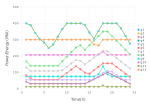

In [56]:
#Generation plan plot
plot1=plot(GenPower, x = Row.index, y=Col.value(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),
    color=Col.index(:g1,:g2,:g3,:g4,:g5,:g6,:g7,:g8,:g9,:g10,:g11,:g12),  
    Geom.line,
    Geom.point,
    white_panel,
    
Guide.XLabel("Time(h)"),
Guide.YLabel("Power/Energy (MW)"),
Guide.colorkey(title = "")
#Guide.Title("Title")
)

In [58]:
#Power balance plot
PowerBalance = DataFrame();
PowerBalance[:Demand] = sum(Pload)*d[:];
PowerBalance[:Generation] = sum(getvalue(p[g,:]) for g=1:NG)*Sbase;
PowerBalance[:SOC] = sum(getvalue(SOC[i,:]) for i=1:NI)*Sbase;
PowerBalance[:Wind] = sum(getvalue(pw[i,:]) for i=1:NI)*Sbase;
#PowerBalance

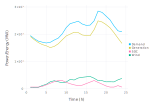

In [59]:
#Power balance plot
plot2=plot(PowerBalance, x = Row.index, y=Col.value(:Demand,:Generation,:SOC,:Wind),
    color=Col.index(:Demand,:Generation,:SOC,:Wind),  
    Geom.line,
    white_panel,
    
Guide.XLabel("Time (h)"),
Guide.YLabel("Power/Energy (MW)"),
#Guide.Title("Title")
Guide.colorkey(title = "")
)

In [61]:
#Charge/Discharge plot
set_default_plot_size(15cm, 7cm)
i=21; #there are ESS in buses 19 and 21 (choose one)
ESS = DataFrame();
ESS[:Charge] = getvalue(pc[i,:])*Sbase;
ESS[:Discharge] = getvalue(pd[i,:])*Sbase;
ESS[:SOC] = getvalue(SOC[i,:])*Sbase ;

#ESS

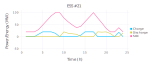

In [47]:
#Charge/Discharge plot
plot3=plot(ESS, x = Row.index, y=Col.value(:Charge,:Discharge,:SOC),
    color=Col.index(:Charge,:Discharge,:SOC),  
    Geom.line,
    white_panel,
     
Guide.XLabel("Time (h)"),
Guide.YLabel("Power/Energy (MW)"),
Guide.Title("ESS #$(i)"),
Guide.colorkey(title = "")
)